<a href="https://colab.research.google.com/github/mzijewel/MachineLearning/blob/master/tree/master/Supervised/Classifcation/Cifar10PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
from torch.utils.mobile_optimizer import optimize_for_mobile

import torch.nn as nn
import torch.nn.functional as F


import matplotlib.pyplot as plt
import numpy as np

from PIL import Image

In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
     ])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170498071/170498071 [00:06<00:00, 24829629.49it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


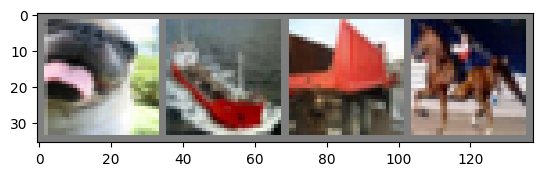

dog   ship  truck horse


In [4]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [6]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5) # input (RGB channel) = 3, Out = 6, Filter = 5
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5) # input 6 must be same as prev out 
        self.fc1 = nn.Linear(16 * 5 * 5, 120) # 16*5*5 using layer count eqn (W-F+2P)S+1
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        # x = x.view(-1, 16*5*5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [25]:
model = Model().to(device)

In [26]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
# optimizer = optim.SGD(model.parameters(), lr=0.01)
# optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
def train(num_epch):
  model.train()
  for epoch in range(num_epch):  # You can adjust the number of epochs
      running_loss = 0.0
      for i, data in enumerate(trainloader, 0):
          inputs, labels = data[0].to(device),data[1].to(device)
          optimizer.zero_grad()
          outputs = model(inputs)
          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()
          running_loss += loss.item()
          if i % 2000 == 1999:  # print every 2000 mini-batches
              print('[%d, %5d] loss: %.3f' %
                    (epoch + 1, i + 1, running_loss / 2000))
              running_loss = 0.0

  print('Finished Training')


def test_accuracy():
  global score
  model.eval()
  correct = 0
  total = 0
  # since we're not training, we don't need to calculate the gradients for our outputs
  with torch.no_grad():
      for data in testloader:
          images, labels = data[0].to(device),data[1].to(device)
          # calculate outputs by running images through the network
          outputs = model(images)
          # the class with the highest energy is what we choose as prediction
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()

  score=100 * correct // total
  print(f'Accuracy of the network on the 10000 test images: {score} %')

def test_accuracy_all():

  # prepare to count predictions for each class
  correct_pred = {classname: 0 for classname in classes}
  total_pred = {classname: 0 for classname in classes}

  # again no gradients needed
  with torch.no_grad():
      for data in testloader:
          images, labels = data[0].to(device),data[1].to(device)
          outputs = model(images)
          _, predictions = torch.max(outputs, 1)
          # collect the correct predictions for each class
          for label, prediction in zip(labels, predictions):
              if label == prediction:
                  correct_pred[classes[label]] += 1
              total_pred[classes[label]] += 1


  # print accuracy for each class
  for classname, correct_count in correct_pred.items():
      accuracy = 100 * float(correct_count) / total_pred[classname]
      print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')


def predict(model,img_path):
  with torch.no_grad():
    img=Image.open(img_path).resize((32,32))
    # img_tns=torchvision.transforms.ToTensor()(img).unsqueeze(0)
    img_tns=transform(img).unsqueeze(0)
    result=model(img_tns)
    probabilities=torch.softmax(result[0],dim=0)
    # max_indx=torch.argmax(probabilities)
    max_val,max_indx=torch.max(probabilities,dim=0)
    item=classes[max_indx]
    print(f'{img_path}-{item} : {max_val*100:0.2f}% : index {max_indx}')


def save_weight():
  path=f'm-{score}.pth'
  torch.save(model.state_dict(), path)

def load_weight(path):
  model = Model()
  model.load_state_dict(torch.load(path))
  return model

def save_model(name):
  model.eval()
  input=torch.randn(1,3,32,32)
  m=torch.jit.trace(model.to(torch.device('cpu')),input)
  torch.jit.save(m,name)
  # s=optimize_for_mobile(m)
  # s._save_for_lite_interpreter('m10.ptl') # this prediction is not correct


def load_model(path):
  model=torch.jit.load(path)
  model.eval()
  # count=sum(p.numel() for p in model.parameters())
  # print(f"prams: {count}")
  return model

def test_model(path):
  model=load_model(path)
  imgs=['cat.jpg','dog.jpg','car.jpeg',"deer.jpeg","hen.jpeg"]
  for img in imgs:
    predict(model,f'/content/{img}')

In [ ]:
train(1)
test_accuracy()

In [ ]:
m=f'm-{score}.pt'
save_model(m)
test_model(m)